In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression as lr,Ridge,Lasso,RidgeCV,LassoCV
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [2]:
data=pd.read_csv("76 - Hitters.csv")
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
predict=data[data['Salary'].isnull()]
data=data[~data['Salary'].isnull()]

In [4]:
inputs=data.drop('Salary',axis=1)
target=data['Salary']

###### Splitting the data

In [5]:
inputs=pd.get_dummies(inputs,drop_first=True)
#Splitting the data
x_train,x_test,y_train,y_test=tts(inputs,target,random_state=365,test_size=0.35)

###### Standardizing inputs

In [6]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

###### Checking for correlation and outliers

<Axes: xlabel='Salary', ylabel='Count'>

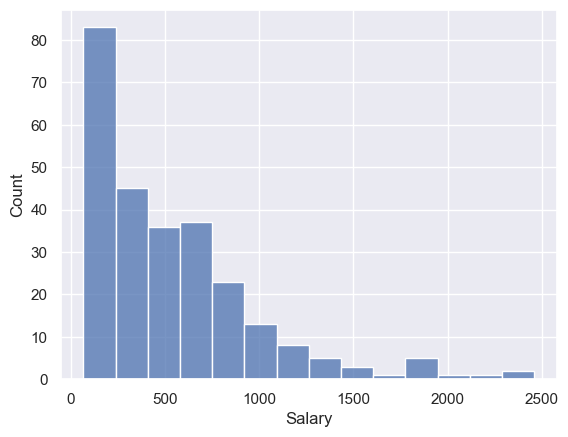

In [7]:
sns.histplot(target)

In [8]:
#We see presence of outliers therefore ols will result in a poor estimate , so we might want ridge/lasso instead

In [9]:
corr=data.corr()
corr['Salary'].sort_values(ascending=True)
#Presence of useless features , lasso might be a better choice unless we want to manually Feature select

C:\Users\mmopa\AppData\Local\Temp\ipykernel_648\3997061313.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=data.corr()


Errors    -0.005401
Assists    0.025436
PutOuts    0.300480
HmRun      0.343028
AtBat      0.394771
Years      0.400657
Runs       0.419859
Hits       0.438675
Walks      0.443867
RBI        0.449457
CWalks     0.489822
CHmRun     0.524931
CAtBat     0.526135
CHits      0.548910
CRuns      0.562678
CRBI       0.566966
Salary     1.000000
Name: Salary, dtype: float64

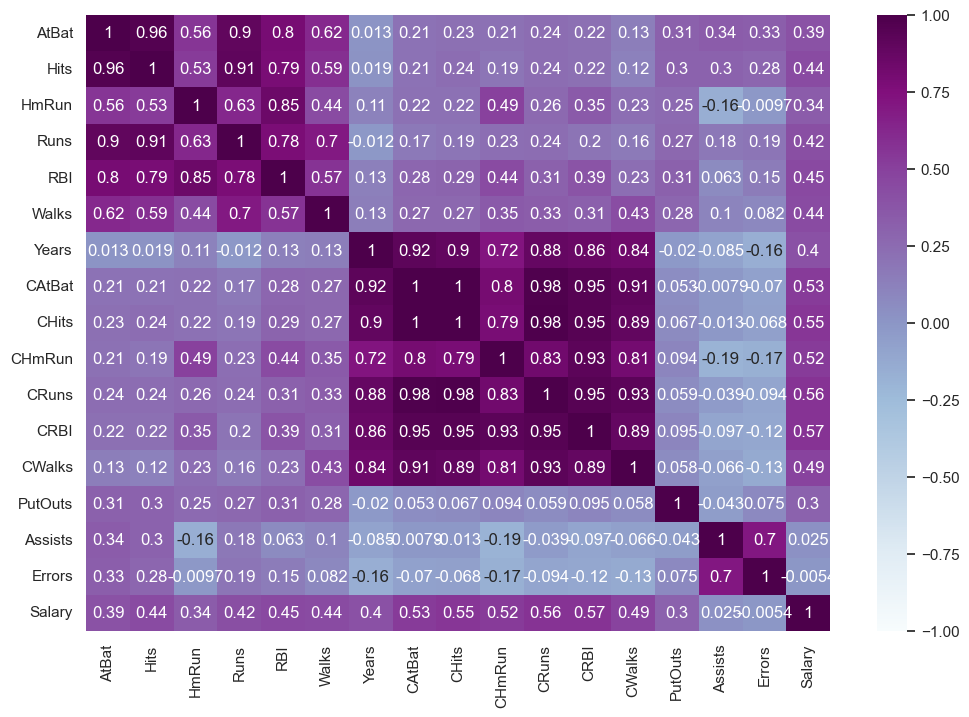

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(corr,vmin=-1,vmax=1,annot=True,cmap='BuPu')
plt.show()
#Presence of multiple correlated features 'dark purple' multicollinearity

######   Applying LR

In [11]:
#Linear Regression
lr=lr()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)

In [12]:
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R^2 for train: ",lr.score(x_train,y_train))
print("R^2 for test: ",lr.score(x_test,y_test))

RMSE:  313.239567899406
R^2 for train:  0.568058916051897
R^2 for test:  0.3455994829736344


##### Cross validation for ridge/lasso

##### Ridge

In [13]:
cv=RepeatedKFold(n_splits=5,n_repeats=3,random_state=1)
ridge=RidgeCV(alphas=np.arange(0.1,10,0.1),cv=cv,scoring='neg_mean_absolute_error')
ridge.fit(x_train,y_train)
y_pred=ridge.predict(x_test)
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R^2 for train: ",ridge.score(x_train,y_train))
print("R^2 for test: ",ridge.score(x_test,y_test))

RMSE:  288.6230832527281
R^2 for train:  0.5278667721769686
R^2 for test:  0.4444124247349728


##### Lasso

In [14]:
lasso=LassoCV(alphas=np.arange(0.1,10,0.1),cv=cv,tol=1)
lasso.fit(x_train,y_train)
y_pred=lasso.predict(x_test)

In [15]:
print("RMSE: ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R^2 for train: ",lasso.score(x_train,y_train))
print("R^2 for test: ",lasso.score(x_test,y_test))
print(lasso.alpha_)

RMSE:  304.2072505265753
R^2 for train:  0.4482426197173428
R^2 for test:  0.3827948756282943
8.2


##### Replacing nan with prediction from Ridge
###### Since it performed better , has lower RMSE

In [16]:
nan_x=predict.drop('Salary',axis=1)

In [17]:
predict_x=pd.get_dummies(nan_x,drop_first=True)
predict_x=scaler.fit_transform(predict_x)

In [18]:
predict_y=ridge.predict(predict_x)

In [19]:
nan_x['Salary']=predict_y
nan_x.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague,Salary
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,A,392.789405
15,183,39,3,20,15,11,3,201,42,3,20,16,11,A,W,118,0,0,A,81.671083
18,407,104,6,57,43,65,12,5233,1478,100,643,658,653,A,W,912,88,9,A,1020.542800
22,22,10,1,4,2,1,6,84,26,2,9,9,3,A,W,812,84,11,A,328.052411
30,313,84,9,42,30,39,17,6890,1833,224,1033,864,1087,A,W,127,221,7,A,731.703297
